In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score

import pickle
import scipy.io
from bci_funcs import windowed_mean, base_correct, drop_baseline
import mne

path = '/Volumes/projects/Lukas_Gehrke/2021-fastReach/data/study/eeglab2python/'

# Imports

# Plot grand mean ERP

## By condition: Baseline, EMS1, EMS2

In [ ]:
channel = 23

design_all = pd.DataFrame()
c_move_all = pd.DataFrame()
c_idle_all = pd.DataFrame()

pIDs = [2,3]

for pID in pIDs:

    pID = 'sub-0' + "%02d" % (pID)
    chans = np.array(pd.read_csv(path+pID+'/sel_chans.csv', header=None)).flatten()
    chans = chans - 1 # Matlab to python indexing
    c_ix = np.where(chans==channel)[0][0] # Index of C3
    chans_names = pd.read_csv(path+pID+'/sel_chans_names.csv')

    # Load data
    design = pd.read_csv(path+pID+'/design.csv')
    design_all = pd.concat([design_all, design], axis=0)

    tmp_move = scipy.io.loadmat(path+pID+'/pre_move.mat')
    tmp_move = tmp_move['move'][c_ix,:,:] - tmp_move['move'][c_ix,0:24,:].mean(axis=0)
    c_move = pd.DataFrame(tmp_move).T
    c_move_all = pd.concat([c_move_all, c_move], axis=0)

    tmp_idle = scipy.io.loadmat(path+pID+'/idle.mat')
    tmp_idle = tmp_idle['idle'][c_ix,:,:] - tmp_idle['idle'][c_ix,0:24,:].mean(axis=0)
    c_idle = pd.DataFrame(tmp_idle).T
    c_idle_all = pd.concat([c_idle_all, c_idle], axis=0)

design_all.reset_index(drop=True, inplace=True)
c_move_all.reset_index(drop=True, inplace=True)
c_idle_all.reset_index(drop=True, inplace=True)

design_vars = design_all.columns
data_vars = c_move_all.columns
design_data = design_all.join(c_move_all)
design = design_data.melt(id_vars=design_vars, value_vars=data_vars, var_name='time', value_name='amplitude')
design['time'] = (((1/250) * (design["time"].astype(int)))*1000) - 1000


In [ ]:
with sns.plotting_context('paper', font_scale = 1.8):
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    fig.patch.set_alpha(1)
    sns.despine()
    sns.lineplot(data=design, y='amplitude', x='time', hue='condition', ci=95)
    ax.set(xlabel='Time (ms)', ylabel='µV', title=chans_names.Var1[channel])
    fig.savefig(path + chans_names.Var1[channel] + '_condition.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
    fig.savefig(path + chans_names.Var1[channel] + '_condition.eps', format='eps', transparent=False, bbox_inches='tight', dpi=300)

## By mental state: pre_movement vs. idle

In [ ]:
pre_move_class = np.ones((c_move_all.shape[0], 1))
idle_class = np.zeros((c_idle_all.shape[0], 1))
classes = pd.DataFrame(np.concatenate((pre_move_class, idle_class)).ravel(), columns=['Mental State']).reset_index(drop=True)
classes['Mental State'].replace({'0.0': 'Idle', '1.0': 'Pre Movement'}, inplace=True)

erp = pd.concat([c_move_all, c_idle_all], axis=0).reset_index(drop=True)
design_data = pd.concat([classes, erp], axis=1)
design = design_data.melt(id_vars='Mental State', value_vars=data_vars, var_name='time', value_name='amplitude')
design['time'] = (((1/250) * (design["time"].astype(int)))*1000) - 1000

In [ ]:
with sns.plotting_context('paper', font_scale = 1.8):
    fig, ax = plt.subplots(1, 1, figsize=(6,4.5))
    fig.patch.set_alpha(1)
    sns.despine()
    sns.lineplot(data=design, y='amplitude', x='time', hue='Mental State', ci=95)
    ax.set(xlabel='Time (ms)', ylabel='µV', title=chans_names.Var1[channel])
    fig.savefig(path + chans_names.Var1[channel] + '_mental_state.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
    fig.savefig(path + chans_names.Var1[channel] + '_mental_state.eps', format='eps', transparent=False, bbox_inches='tight', dpi=300)
    

# Plot scalp maps

In [ ]:
# TODO use preprocessed EEG data (interpolated bad channels) with all 65 channels

pre_move_all = np.zeros((63, 250, len(pIDs)))
idle_all = np.zeros((63, 250, len(pIDs)))

for pID in pIDs:

    this_pID = 'sub-0' + "%02d" % (pID)

    # chans = np.array(pd.read_csv(path+this_pID+'/sel_chans.csv', header=None)).flatten()
    # chans = chans - 1 # Matlab to python indexing

    design = pd.read_csv(path+this_pID+'/design.csv')
    good_trials = design.index[design.noisy_erp == 'no']

    pre_move = scipy.io.loadmat(path+this_pID+'/pre_move.mat')
    pre_move = pre_move['move'][:,:,good_trials]
    # pre_move = pre_move['move'][chans,:,:]
    # pre_move = pre_move[:,:,good_trials]
    pre_move = pre_move.mean(axis=2)
    pre_move = pre_move.T - pre_move[:,0:24].mean(axis=1)
    pre_move = pre_move.T   
    pre_move_all[:,:,pID-2] = pre_move

    idle = scipy.io.loadmat(path+this_pID+'/idle.mat')
    idle = idle['idle'][:,:,good_trials]
    # idle = idle['idle'][chans,:,:]
    # idle = idle[:,:,good_trials]
    idle = idle.mean(axis=2)
    idle = idle.T - idle[:,0:24].mean(axis=1)
    idle = idle.T
    idle_all[:,:,pID-2] = idle

move = pre_move_all.mean(axis=2)
idle = idle_all.mean(axis=2)

# scalp topographies
channel_labels = chans_names['Var1'].values.tolist()
# channel_labels = channel_labels[chans]
chans_types = ['eeg'] * channel_labels.__len__()
info = mne.create_info(channel_labels, ch_types=chans_types, sfreq=250)
easycap_montage = mne.channels.make_standard_montage('easycap-M1')

raw = mne.EvokedArray(move, info, tmin=-1)
raw.set_montage(easycap_montage)
times = np.arange(-1, 0, 0.1)
fig = raw.plot_topomap(times, ch_type='eeg', time_unit='s', show_names=False)
fig.savefig(path + '/grand_mean_topomap_pre_move.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
fig.savefig(path + '/grand_mean_topomap_pre_move.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

raw = mne.EvokedArray(idle, info, tmin=-1)
raw.set_montage(easycap_montage)
times = np.arange(-1, 0, 0.1)
fig = raw.plot_topomap(times, ch_type='eeg', time_unit='s', show_names=False)
fig.savefig(path + '/grand_mean_topomap_idle.png', format='png', transparent=False, bbox_inches='tight', dpi=300)
fig.savefig(path + '/grand_mean_topomap_idle.eps', format='eps', transparent=True, bbox_inches='tight', dpi=300)

# Classifier Evaluation

In [79]:
# settings
windows = 10
baseline = 250/10 # 100 ms baseline

pIDs = [2,3]

# for pID in pIDs:
pID = 3

pID = 'sub-0' + "%02d" % (pID)

# Load data
design = pd.read_csv(path+pID+'/design.csv')
chans = np.array(pd.read_csv(path+pID+'/sel_chans.csv', header=None)).flatten()
chans = chans - 1 # Matlab to python indexing

tmp_move = scipy.io.loadmat(path+pID+'/pre_move.mat')
tmp_move = tmp_move['move'][chans,:,:]
tmp_move_means = np.zeros((tmp_move.shape[0] * windows, tmp_move.shape[2]))
for trial_ix in range(0, tmp_move.shape[2]):
    tmp = base_correct(tmp_move[:,:,trial_ix], baseline-1)
    tmp_move_means[:,trial_ix] = windowed_mean(tmp, windows = windows).flatten()

tmp_idle = scipy.io.loadmat(path+pID+'/idle.mat')
tmp_idle = tmp_idle['idle'][chans,:,:]
tmp_idle_means = np.zeros((tmp_idle.shape[0] * windows, tmp_idle.shape[2]))
for trial_ix in range(0, tmp_idle.shape[2]):
    tmp = base_correct(tmp_idle[:,:,trial_ix], baseline-1)
    tmp_idle_means[:,trial_ix] = windowed_mean(tmp, windows = windows).flatten()

# Remove noisy trials
# good_trials = design.index[design.noisy_erp == 'no']
# tmp_move_means = tmp_move_means[:,good_trials]
# tmp_idle_means = tmp_idle_means[:,good_trials]
# design = design.iloc[good_trials].reset_index(drop=True)

# Classifier training on baseline data
baseline_trials = design.index[design.condition == 'baseline']
idle_baseline = tmp_idle_means[:,baseline_trials]
idle_class = np.zeros((idle_baseline.shape[1], 1))
move_baseline = tmp_move_means[:,baseline_trials]
move_class = np.ones((move_baseline.shape[1], 1))

train_data = np.concatenate((move_baseline, idle_baseline), axis = 1).T
train_class = np.concatenate((move_class, idle_class)).ravel()

clf = LDA(solver='eigen', shrinkage='auto')
clf.fit(train_data, train_class)

kfolds = KFold(n_splits=5, random_state=1, shuffle=True) 
cv_results = cross_val_score(clf, train_data, train_class, cv=kfolds)
print(cv_results.mean())
print(cv_results.std())

0.7333333333333334
0.11737877907772674


In [80]:
rf = RandomForestClassifier(max_depth=2, random_state=0)
lda_scores_training = clf.transform(train_data)
rf.fit(lda_scores_training, train_class)

RandomForestClassifier(max_depth=2, random_state=0)

## Histogram LDA Scores

In [84]:
# get data
trials = design.index[design.condition == 'ems2']
idle = tmp_idle_means[:,trials]
idle_class = np.zeros((idle.shape[1], 1))
move = tmp_move_means[:,trials]
move_class = np.ones((move.shape[1], 1))

data = np.concatenate((move, idle), axis = 1).T
classes = np.concatenate((move_class, idle_class)).ravel()

In [85]:
print('Accuracy score : \n' + str(accuracy_score(classes, clf.predict(data))))

lda_scores_experiment = clf.transform(data)
y_pred = rf.predict(lda_scores_experiment)

print('Accuracy score : \n' + str(accuracy_score(classes, y_pred)))

Accuracy score : 
0.5405405405405406
Accuracy score : 
0.5405405405405406


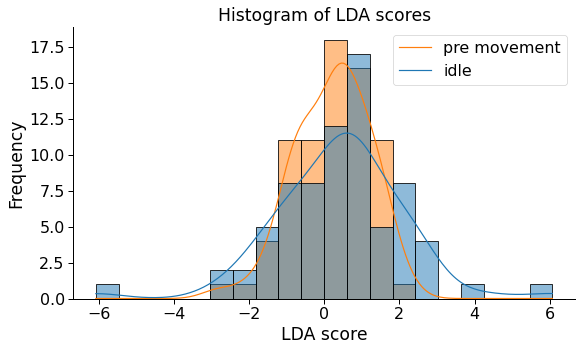

In [86]:
lda_scores = clf.transform(data)

df_to_plot = pd.DataFrame()
df_to_plot['scores'] = pd.DataFrame(lda_scores)
df_to_plot['classes'] = pd.DataFrame(classes)

with sns.plotting_context('paper', font_scale = 1.8):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    fig.patch.set_alpha(1)
    sns.despine() #bottom=True, left=True 

    sns.histplot(data=df_to_plot, x='scores', hue=classes, kde=True)

    ax.set(xlabel='LDA score', ylabel='Frequency', title='Histogram of LDA scores')
    ax.legend(['pre movement', 'idle'])

0.38752918915738416

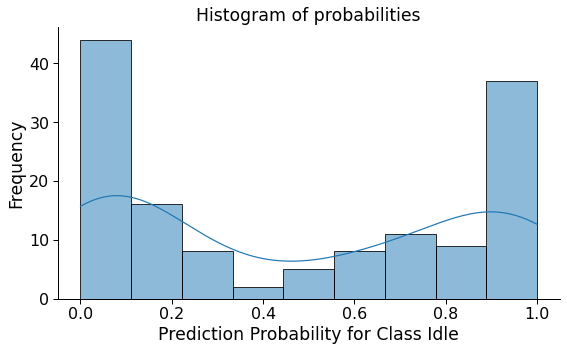

In [77]:
probs = np.round(clf.predict_proba(data)[:,0],2)
# probs = np.round(clf.predict_proba(pre_move_ems1_means)[:,1],2)
# probs = np.round(clf.predict_proba(pre_move_means)[:,1],2)
# probs = np.round(clf.predict_proba(idle_means)[:,0],2)

with sns.plotting_context('paper', font_scale = 1.8):
    fig, ax = plt.subplots(1, 1, figsize=(9,5))
    fig.patch.set_alpha(1)
    sns.despine() #bottom=True, left=True 

    sns.histplot(data=probs, kde=True)

    ax.set(xlabel='Prediction Probability for Class Idle', ylabel='Frequency', title='Histogram of probabilities')

probs.std()

# Resources

In [ ]:
# windowed means
# c_move_all_windowed_means = pd.DataFrame(windowed_mean(np.array(c_move_all), 10))
# c_idle_all_windowed_means = pd.DataFrame(windowed_mean(np.array(c_idle_all), 10))

# design_vars = design_all.columns
# data_vars = c_move_all_windowed_means.columns
# design_data = design_all.join(c_idle_all_windowed_means)
# design = design_data.melt(id_vars=design_vars, value_vars=data_vars, var_name='time', value_name='amplitude')
# sns.lineplot(data=design, y='amplitude', x='time', hue='condition', ci=95)


# # plot patterns and filters
# from mne.decoding import LinearModel

# chans_names = pd.read_csv(path+pID+'/sel_chans_names.csv')
# channel_labels = chans_names['Var1'].values.tolist()
# channel_labels = channel_labels[0:-1]
# channel_labels = np.array(channel_labels)[chans].tolist()
# chans_types = ['eeg'] * channel_labels.__len__()

# info = mne.create_info(channel_labels, ch_types=chans_types, sfreq=10)
# easycap_montage = mne.channels.make_standard_montage('easycap-M1')
# times = np.arange(-1, 0, 0.1)

# # create a linear model with LogisticRegression
# model = LinearModel(clf)
# model.fit(data, classes)

# # Extract and plot spatial filters and spatial patterns
# for name, coef in (('patterns', model.patterns_), ('filters', model.filters_)):
#     # We fitted the linear model onto Z-scored data. To make the filters
#     # interpretable, we must reverse this normalization step
#     # coef = scaler.inverse_transform([coef])[0]

#     # The data was vectorized to fit a single model across all time points and
#     # all channels. We thus reshape it:
#     coef = coef.reshape(len(chans), -1)

#     # Plot
#     evoked = mne.EvokedArray(coef, info, tmin=-1)
#     evoked.set_montage(easycap_montage)

#     fig = evoked.plot_topomap(times)
#     fig.suptitle(f'MEG {name}')